# BES Analysis in the Vertical Direction

Import neccesary packages

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from plotting_functions_BES import *
import seaborn as sns
import pandas as pd

Read BES data

In [4]:
# for BES data
# (R, z) locations for the BES channels (view location)
apdpos = np.asarray(xr.open_dataarray('Data\\shot29378_apdpos.nc'))

fluct_data_from_file = xr.open_dataarray('Data\\shot29378_LH_fluct_data.nc')

bes_time = np.asarray(fluct_data_from_file.coords['time']) # bes_time[0:992499]
fluct_data = np.asarray(fluct_data_from_file) # fluct_data[0:31][0:992499]

Define interesting timeslices

In [5]:
regions = [[0.16,0.24], [0.36,0.54], [0.54,0.68]]

Define function to find the k-f spectrum given a BES column and timeslice. Returns  the axes - frequencies in kHz, wavenumbers in m$^{-1}$ - and the spectrum itself.

In [6]:
def get_kf_spec(col, timeslice): # Col is int from 0 to 7 . timeslice = [t1, t2], a 2x1 array
    channels = []
    for i in range(4): # For the given column, get each channel index
        channels.append(i*8+col)
    
    space_array = [apdpos[i][1] for i in channels] # Get Z-coordinates of each channel
    space_array = np.asarray(space_array)
    spec = []
    for ch in channels: # FFT each channel in time
        fft = get_channel_fft(29378, bes_time, fluct_data, ch, timeslice, "channel_fft")
        f_transform = fft[1]
        spec.append(f_transform) # Each row of spec corresponds to a channel.
    f_arr = fft[0] # Frequency array is the same for all of them so just save any one.
    
    spec = np.asarray(spec)
    spec = np.transpose(spec) # Now each row is a time point as required by calc_kspecs
    calc = calc_kspec(spec, space_array) # Get k-f spectrum
    
    kf_matrix = calc[0] # This contains the transform data
    k_arr = calc[1] # This is the array of wavenumbers
    
    return f_arr, k_arr, kf_matrix

Function for plotting the k-f spectra as a heatmap

In [7]:
def plot_kf_spec_vertical(region, col, f_arr, k_arr, kf_matrix, fint=50.0, fmin=0.0, fmax=None, save=True):
    if fmax == None:
        fmax = np.max(f_arr)
    # Only need to plot a section of the spectrum. At least half not needed.
    kf_matrix = kf_matrix[(np.abs(f_arr - fmin)).argmin():(np.abs(f_arr - fmax)).argmin()]
    f_arr = f_arr[(np.abs(f_arr - fmin)).argmin():(np.abs(f_arr - fmax)).argmin()]
    
    # Convert to array with rounded frequencies for easier of plotting.
    kf_matrix_plot = pd.DataFrame(kf_matrix, index=np.around(f_arr,0), columns=np.around(k_arr,1))
    
    # For only plotting tick at every 50 kHz
    interval = int(np.abs(f_arr - fint).argmin())

    # Plot log of values so small enough range for features to be visible
    sns.heatmap(np.log(np.abs(kf_matrix_plot)**2)[::-1], yticklabels=interval, cmap="plasma", cbar_kws={"label": r"$\log\vert S(f,k)\vert^2$"})
    plt.title("Region " + str(region) + ", t=" + str(regions[region-1]) + " s, Column " + str(col) + " (vertical)")
    plt.ylabel("Frequency [kHz]")
    plt.xlabel(r"Wavenumber [m$^{-1}$]")
    if save == True:
        plt.savefig("Plots/Good kf_specs/Vertical/" + datestamp + "/kf_spec_reg_" + str(region) + "_col_" + str(col) + ".png", format="png", bbox_inches="tight", dpi=300)
    else:
        plt.show()
    plt.close()

Calculate and plot k-f spectra for each region for each of the three left-most columns.

In [8]:
"""for region in range(3):
    for col in range(3):
        tmp = get_kf_spec(col,regions[region])
        plot_kf_spec_vertical(region+1, col, tmp[0], tmp[1], tmp[2], fmax=250.0, save=False)"""

'for region in range(3):\n    for col in range(3):\n        tmp = get_kf_spec(col,regions[region])\n        plot_kf_spec_vertical(region+1, col, tmp[0], tmp[1], tmp[2], fmax=250.0, save=False)'

Function for summing contributions for each wavenumber OR frequency to produce a spectrum of FFT against frequency OR wavenumber

In [9]:
def kf_sum(kf_matrix, keep_var): # keep_var is the variable not summed over. E.g. if f it sums ks for each f.
    if keep_var == "k":
        spec = np.sum(kf_matrix, axis=0)
    elif keep_var == "f":
        spec = np.sum(kf_matrix, axis=1)
    else:
        raise ValueError("Bad argument keep_var = " + keep_var)
    return spec

Function for plotting the spectrum of FFT against $f$ or $k$

In [10]:
def plot_kf_sum(region, col, keep_var, kf_axis, spec, save=True):  
    
    # If spec is S(f) limit axes to show points above 1% of max value, so shape clearer.
    if keep_var == "f":
        plt.plot(kf_axis, np.log(np.abs(spec)**2), color="k", linewidth=0.05)
        spec_max = np.max(spec)
        idx = 0
        for i in spec:
            if i > 0.01*spec_max:
                xlim = kf_axis[idx]
                break
            idx += 1
        plt.xlim([-xlim,xlim])
        plt.xlabel("Frequency [kHz]")
        plt.ylabel(r"$\log\vert\sum_kS(k,f)\vert^2=\log\vert S(f)\vert^2$")
    else:
        plt.plot(kf_axis, np.abs(spec), color="k", linewidth=0.5)
        plt.xlabel(r"Wavenumber [m$^{-1}$]")
        plt.ylabel(r"$\log\vert\sum_fS(k,f)\vert^2=\log\vert S(k)\vert^2$")
    plt.xlim([-200,200])
    plt.title("Region " + str(region) + ", t=" + str(regions[region-1]) + " s, Column " + str(col) + " (vertical)")
    
    if save == True:
        plt.savefig("Plots/kf-summed/Vertical/" + datestamp() + "/" + keep_var + "-sum_reg_" + str(region) + "_col_" + str(col) + ".pdf", format="pdf", bbox_inches="tight", dpi=300)
    else:
        plt.show()
    plt.close()

Function to sum points over a 1D array in a given distinct window. new_freqs is 1/window_size of freqs

In [11]:
def spec_box_sum(spec, freqs, window_length):
    spec_smooth = []
    new_freqs = []
    window_hw = int(np.floor(window_length/2))

    for i in range(int(np.ceil(window_length/2)),len(spec)-window_hw,window_length): # From first to last midpoint
        window_sum = 0
        for j in range(i-window_hw, i+window_hw+1): # +1 to include the end point
            window_sum += spec[j]
        spec_smooth.append(window_sum)
        new_freqs.append(freqs[i])
    return new_freqs, spec_smooth

Plot $S(f)$ using above feature-enhancing function

In [12]:
"""for region in range(3):
    for col in range(3):
        tmp = get_kf_spec(col,regions[region])
        spec = kf_sum(tmp[2], "f")
        plot_kf_sum(region+1, col+1, "f", spec_box_sum(spec, tmp[0], 10)[0], spec_box_sum(spec, tmp[0], 10)[1], save=True)"""

'for region in range(3):\n    for col in range(3):\n        tmp = get_kf_spec(col,regions[region])\n        spec = kf_sum(tmp[2], "f")\n        plot_kf_sum(region+1, col+1, "f", spec_box_sum(spec, tmp[0], 10)[0], spec_box_sum(spec, tmp[0], 10)[1], save=True)'

Function to do same as spec_box_sum but for 2D array

In [13]:
def kf_spec_box_sum(f_arr, k_arr, kf_matrix, window_length):
    kf_matrix = np.transpose(kf_matrix)
    new_matrix = []
    
    for i in kf_matrix:
        summed = spec_box_sum(i, f_arr, window_length)
        new_matrix.append(summed[1])
    return np.asarray(summed[0]), k_arr, np.transpose(np.asarray(new_matrix))

Make kf spectra plots where frequencies summed over a number of points.

In [14]:
"""for region in range(3):
    for col in range(3):
        tmp = get_kf_spec(col,regions[region])
        blocked = kf_spec_box_sum(tmp[0], tmp[1], tmp[2], 10)
        plot_kf_spec_vertical(region+1, col+1, blocked[0], blocked[1], blocked[2], fmax=250, save=False)"""

'for region in range(3):\n    for col in range(3):\n        tmp = get_kf_spec(col,regions[region])\n        blocked = kf_spec_box_sum(tmp[0], tmp[1], tmp[2], 10)\n        plot_kf_spec_vertical(region+1, col+1, blocked[0], blocked[1], blocked[2], fmax=250, save=False)'

In [32]:
def plot_kf_spec_vert_cond(region, col, f_arr, k_arr, kf_matrix, fint=50.0, fmin=0.0, fmax=None, save=True, fn=""):
    if fmax == None:
        fmax = np.max(f_arr)

    # Only need to plot a section of the spectrum. At least half not needed.
    kf_matrix = kf_matrix[(np.abs(f_arr - fmin)).argmin():(np.abs(f_arr - fmax)).argmin()]
    f_arr = f_arr[(np.abs(f_arr - fmin)).argmin():(np.abs(f_arr - fmax)).argmin()]

    # Convert to array with rounded frequencies for easier of plotting.
    kf_matrix_plot = pd.DataFrame(kf_matrix, index=np.around(f_arr,0), columns=np.around(k_arr,1))
    
    # For only plotting tick at every 50 kHz
    interval = int(np.abs(f_arr - fint).argmin())

    # Plot log of values so small enough range for features to be visible
    sns.heatmap(np.log(np.abs(kf_matrix_plot)**2)[::-1], yticklabels=interval, cmap="plasma", cbar_kws={"label": r"$\log\vert S(k|f)\vert^2$"})
    plt.title("Region " + str(region) + ", t=" + str(regions[region-1]) + " s, Column " + str(col) + " (vertical)")
    plt.ylabel("Frequency [kHz]")
    plt.xlabel(r"Wavenumber [m$^{-1}$]")
    if save == True:
        plt.savefig("Plots/kf-conditional/Vertical/" +  datestamp() + "/kf_cond_vert_spec_reg_" + str(region) + "_col_" + str(col) + "_" + fn + ".png", format="png", bbox_inches="tight", dpi=300)
    else:
        plt.show()
    plt.close()

Function to convert $S(f,k) \to S(k|f)$

In [16]:
def normalise_kf(f_arr, kf_matrix, fmin=0.0, fmax=None):
    if fmax == None:
        fmax = np.max(f_arr)

    kf_matrix = kf_matrix[(np.abs(f_arr - fmin)).argmin():(np.abs(f_arr - fmax)).argmin()]
    f_arr = f_arr[(np.abs(f_arr - fmin)).argmin():(np.abs(f_arr - fmax)).argmin()]
    spec = np.transpose(kf_matrix)/np.sum(kf_matrix,axis=1)

    return f_arr, np.transpose(spec)

Produce plots of $S(k|f)$

In [17]:
"""for region in range(3):
    for col in range(3):
        tmp = get_kf_spec(col,regions[region])
        spec = normalise_kf(tmp[0], tmp[2], fmax=250.0)
        blocked = kf_spec_box_sum(spec[0], tmp[1], spec[1], 10)
        plot_kf_spec_vert_cond(region+1, col+1, blocked[0], blocked[1], blocked[2], fmax=250, save=True)"""

'for region in range(3):\n    for col in range(3):\n        tmp = get_kf_spec(col,regions[region])\n        spec = normalise_kf(tmp[0], tmp[2], fmax=250.0)\n        blocked = kf_spec_box_sum(spec[0], tmp[1], spec[1], 10)\n        plot_kf_spec_vert_cond(region+1, col+1, blocked[0], blocked[1], blocked[2], fmax=250, save=True)'

Function to get moving average of 1D array - not currently in use

In [18]:
def spec_rolling_avg(spec, window_length):
    spec_smooth = []
    window_mid = int(np.floor(window_length/2))
    window_left = int(np.floor(window_length/2))
    window_right = int(np.ceil(window_length/2))
    
    for i in range(window_left,len(spec)-window_right):
        window_sum = 0
        for j in range(window_mid-window_left, window_mid+window_right):
            window_sum += spec[j]
        spec_smooth.append(window_sum/window_length)
        window_mid += 1
    return spec_smooth

Making $k$-$f$ spectra for focussing on crashes only.

Function to short-time FFT data, sum up each column and plot it.

In [86]:
def sum_bes_fluct_spectrogram(bes_time, fluct_data, region, col, timeslice, n, freq_lims=[0.0, 200.0], plot=False, save=True):
    # plot the BES fluctuation data spectrogram for one or more channels, L. Howlett adapted by A. Caplan
    idx1 = (np.abs(bes_time - timeslice[0])).argmin()
    idx2 = (np.abs(bes_time - timeslice[1])).argmin()
    channels = []
    for i in range(4): # For the given column, get each channel index
        channels.append(i*8+col)
    
    freq, times, Sxx = sig.spectrogram(fluct_data[:,idx1:idx2], fs=f_samp, 
                                       nperseg=(2 ** n), scaling='spectrum')
    
    num_channels = len(channels)
    new_lim = int(14 * (2 ** (n - 7)))
    new_lim = len(freq)-1
    
    summed_Sxx = np.asarray(Sxx[channels[0]][:new_lim,:])
    for ch in channels[1:]:
        summed_Sxx += Sxx[ch][:new_lim,:]
    
    if plot == True:
        figure, axes = plt.subplots(1, 1, sharex=True, 
                                    figsize=(15, 7))
        axes.set_title('Region ' + str(region+1) + ', Sum of col ' + str(col+1) + ', n=' + 
            str(int(2 ** n)), fontsize=32)    

        ct = axes.contourf(times + bes_time[idx1], 0.001 * freq[:new_lim], 
               summed_Sxx, 16, cmap=plt.get_cmap('plasma'), levels=[10**(i/10) for i in range(-80,10,5)],
                norm=(colors.LogNorm()))

        axes.set_ylim(freq_lims)
        axes.tick_params(axis='y', labelsize=22)
        axes.set_ylabel(r'$f$ [kHz]', fontsize=24)
        cbar = figure.colorbar(ct, shrink=0.9, label="Strength [a.u.]")
        axes.tick_params(axis='x', labelsize=24)
        axes.set_xlabel('time [s]', fontsize=26)
        axes.set_xlim(timeslice)
        plt.tight_layout()

        if save==True:
            plt.savefig("Plots/Spectrograms/Vertical/" +  datestamp() + "/stftt_colsum_reg_" + str(region+1) + "_col_" + str(col+1) + ".png", format="png", bbox_inches="tight", dpi=300)
        else:
            plt.show()
        plt.close()
    
    return freq, times + bes_time[idx1], summed_Sxx

Get strength along line of all time at a given frequency. Use this to work out times of crashes.

In [131]:
def get_spectrogram_line(freq, times, Sxx, f, plot=False):
    fidx = np.abs(freq-f).argmin() # index of line at f
    line = Sxx[fidx,:]
    
    significant = [] # indices of peaks
    # Based on max of middle section to handle some errors 
    for i in range(len(line)):
        if line[i] > 0.4*np.max(line[len(line)*20//100:len(line)*80//100]):
            significant.append(i)

    width = np.max(np.diff(significant))//10
    slices = [] # Pairs of values, with each significant in the middle
    
    # If peak detected too close to end of region, remove last peak from consideration
    windows_inside = False
    while windows_inside == False:
        if significant[-1] + width >= len(line):
            significant = significant[:-1]
        else:
            windows_inside = True
    
    for i in significant:
        slices.append([times[i-width], times[i+width]])
    
    if plot == True:
        plt.plot(times,line, linewidth=0.75)
        plt.plot([times[i] for i in significant], [line[i] for i in significant], "x")
        plt.vlines([times[i-width] for i in significant], 0, np.max(line), "k", "dashed", linewidth=0.5)
        plt.vlines([times[i+width] for i in significant], 0, np.max(line), "b", "dashed",linewidth=0.5)
        plt.show()
        plt.close()
        
    return slices

In [126]:
def spectrogram_box_sum(bes_time, fluct_data, region, col, timeslice, n=8, plot=True, save=False):
    stftt = sum_bes_fluct_spectrogram(bes_time, fluct_data, region, col, timeslice, n, freq_lims=[0.0, 300.0], plot=False, save=False)
    summed = kf_spec_box_sum(stftt[0], stftt[1], stftt[2], 4)
    freq = summed[0]
    times = summed[1]
    summed_Sxx = summed[2]
    
    if plot == True:
        figure, axes = plt.subplots(1, 1, sharex=True, 
                                    figsize=(15, 7))
        axes.set_title('Region ' + str(region+1) + ', Sum of col ' + str(col+1) + ', n=' + 
            str(int(2 ** n)), fontsize=32)    

        ct = axes.contourf(times, 0.001 * freq, 
               summed_Sxx, 16, cmap=plt.get_cmap('plasma'), levels=[10**(i/10) for i in range(-60,10,5)],
                norm=(colors.LogNorm()))

        axes.set_ylim([0.0,250.0])
        axes.tick_params(axis='y', labelsize=22)
        axes.set_ylabel(r'$f$ [kHz]', fontsize=24)
        cbar = figure.colorbar(ct, shrink=0.9, label="Strength [a.u.]")
        axes.tick_params(axis='x', labelsize=24)
        axes.set_xlabel('time [s]', fontsize=26)
        axes.set_xlim(timeslice)
        plt.tight_layout()

        if save==True:
            plt.savefig("Plots/Spectrograms/Vertical/" +  datestamp() + "/stftt_colsum_reg_" + str(region+1) + "_col_" + str(col+1) + ".png", format="png", bbox_inches="tight", dpi=300)
        else:
            plt.show()
        plt.close()
    
    return freq, times, summed_Sxx

In [124]:
def fft_peak_only(region, col, timeslice, line, conditional=True, box_sum=None, plot=True, save=False):
    # Find times where lots of frequencies appear
    stftt = spectrogram_box_sum(bes_time, fluct_data, region, col, timeslice, n=8, plot=False, save=False)
    small_slices = get_spectrogram_line(stftt[0], stftt[1], stftt[2], line*1000, plot=False)
    
    # FFT each spike and combine into one
    first_spike = get_kf_spec(col,small_slices[0])
    peak_sum_kf_matrix = np.asarray(first_spike[2])
    f_arr = np.asarray(first_spike[0])
    k_arr = np.asarray(first_spike[1])

    for peak in range(1,len(small_slices)):
        peak_sum_kf_matrix += get_kf_spec(col,small_slices[peak])[2]
        #plot_kf_spec_vertical(region, col, f_arr, k_arr, peak_sum_kf_matrix,fmax=250.0,save=False)

    if conditional:
        normed_spec = normalise_kf(f_arr, peak_sum_kf_matrix)
        peak_sum_kf_matrix = normed_spec[1]
        f_arr = normed_spec[0]
    
    if box_sum != None:
        blocked_spec = kf_spec_box_sum(f_arr, k_arr, peak_sum_kf_matrix, box_sum)
        f_arr = blocked_spec[0]
        k_arr = blocked_spec[1]
        peak_sum_kf_matrix = blocked_spec[2]

    if plot:
        if conditional:
            plot_kf_spec_vert_cond(region+1, col+1, f_arr, k_arr, peak_sum_kf_matrix, fmax=250.0, save=save, fn="pm")
        else:
            plot_kf_spec_vertical(region+1, col+1, f_arr, k_arr, peak_sum_kf_matrix, fmax=250.0, save=save)

In [130]:
for region in range(3):
    for col in range(8):
        fft_peak_only(region, col, regions[region], 150.0, conditional=True, box_sum=2, plot=True, save=True)

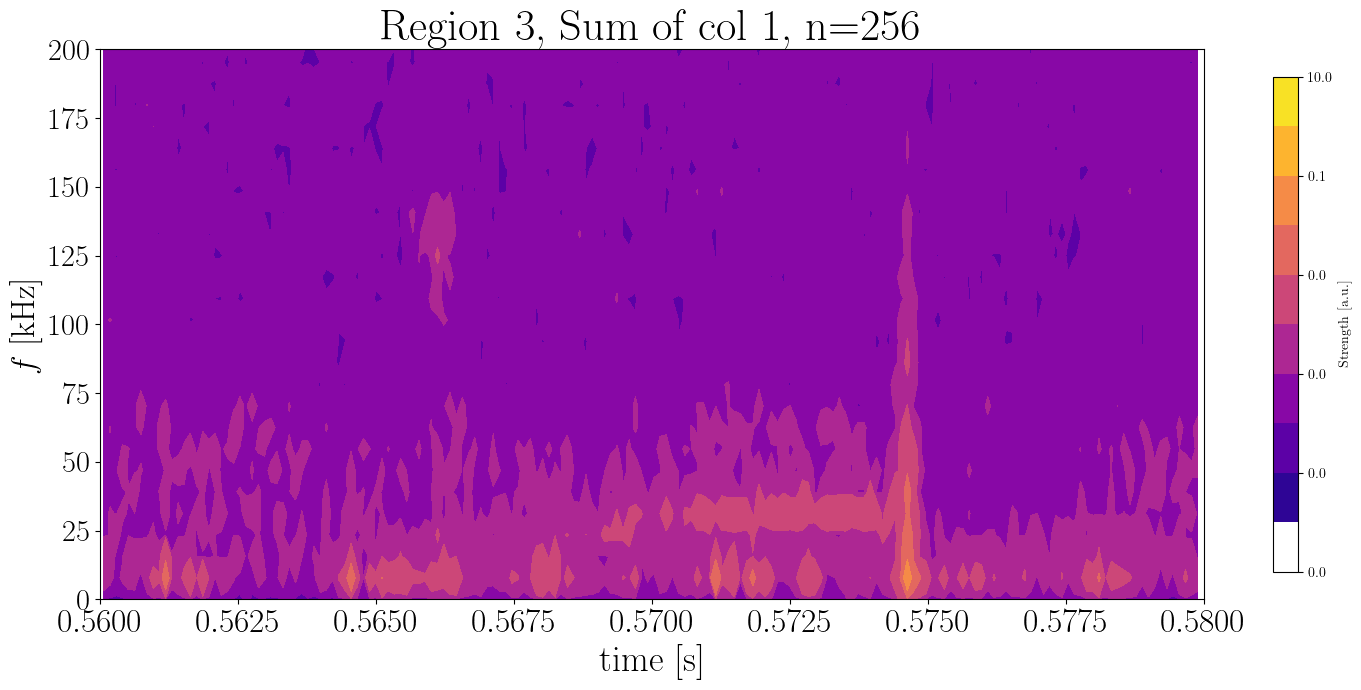

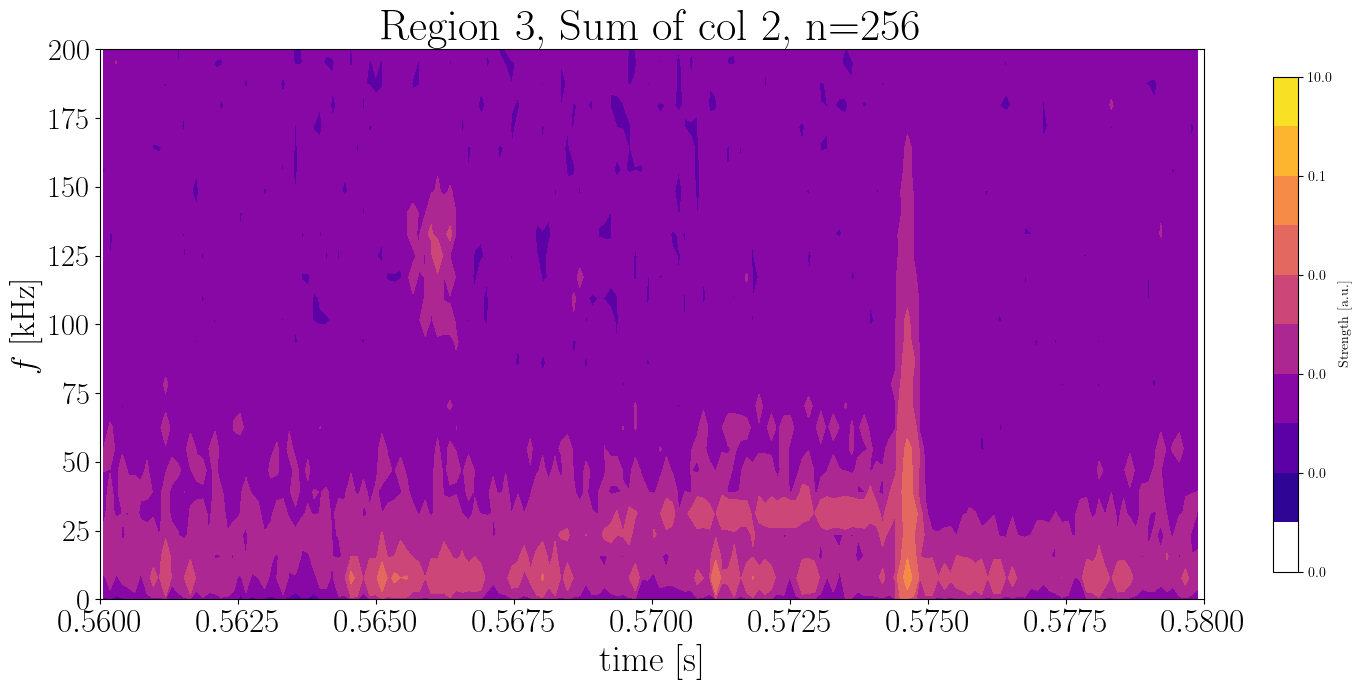

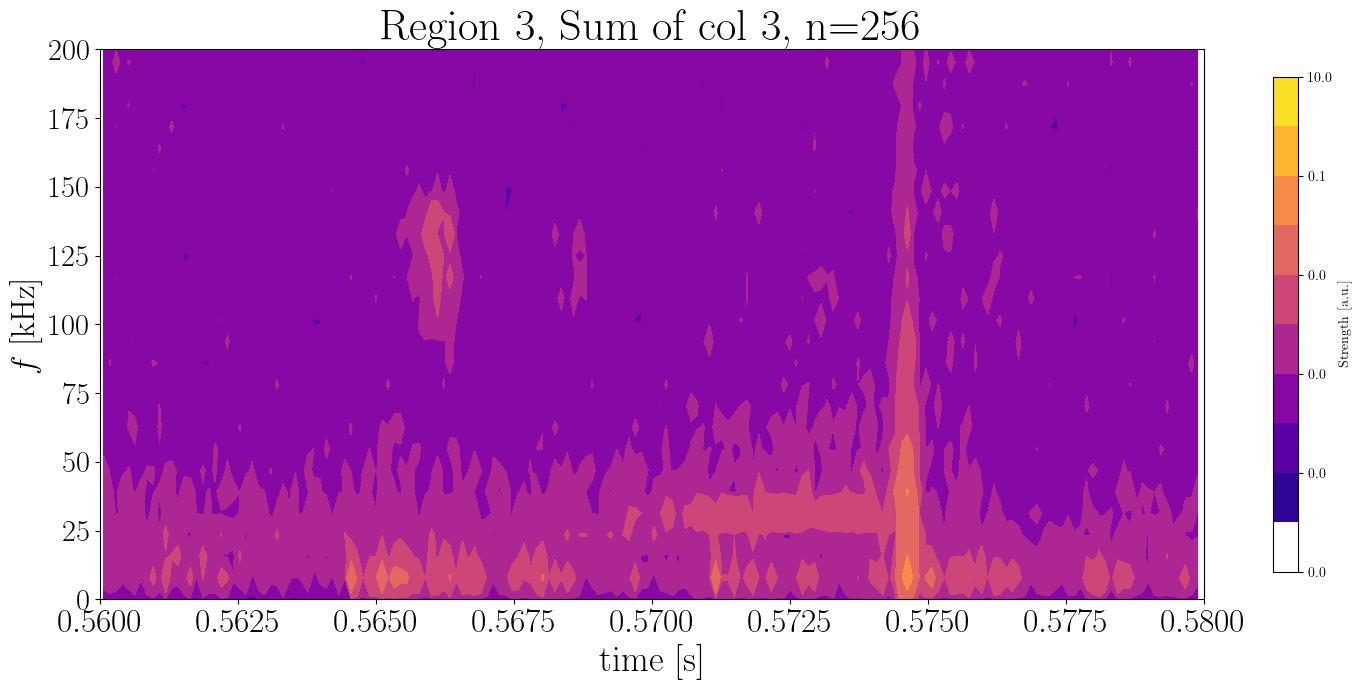

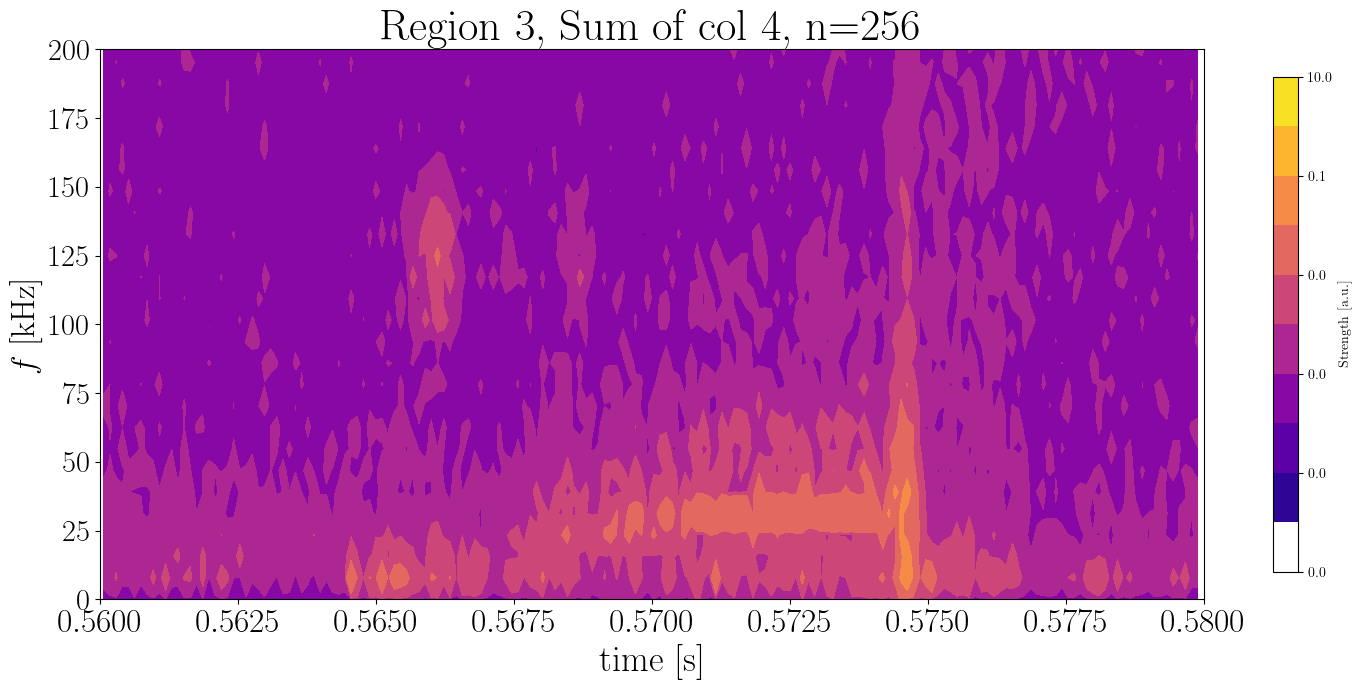

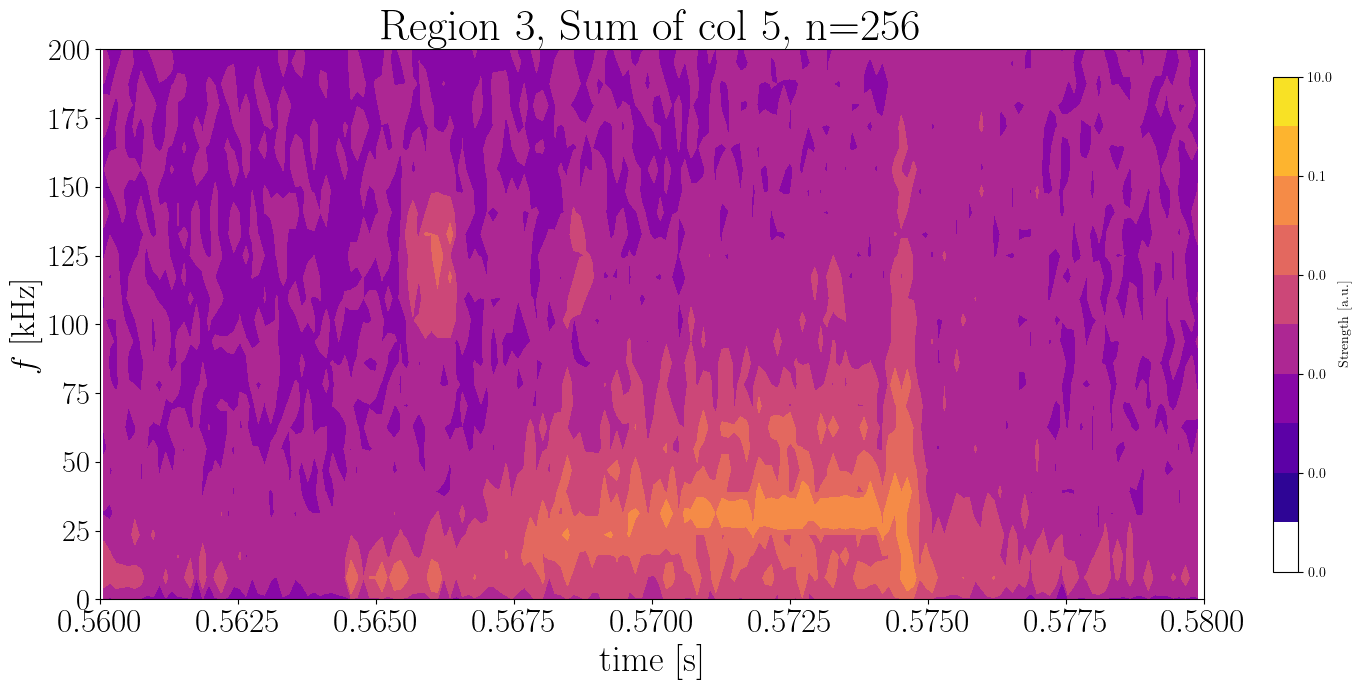

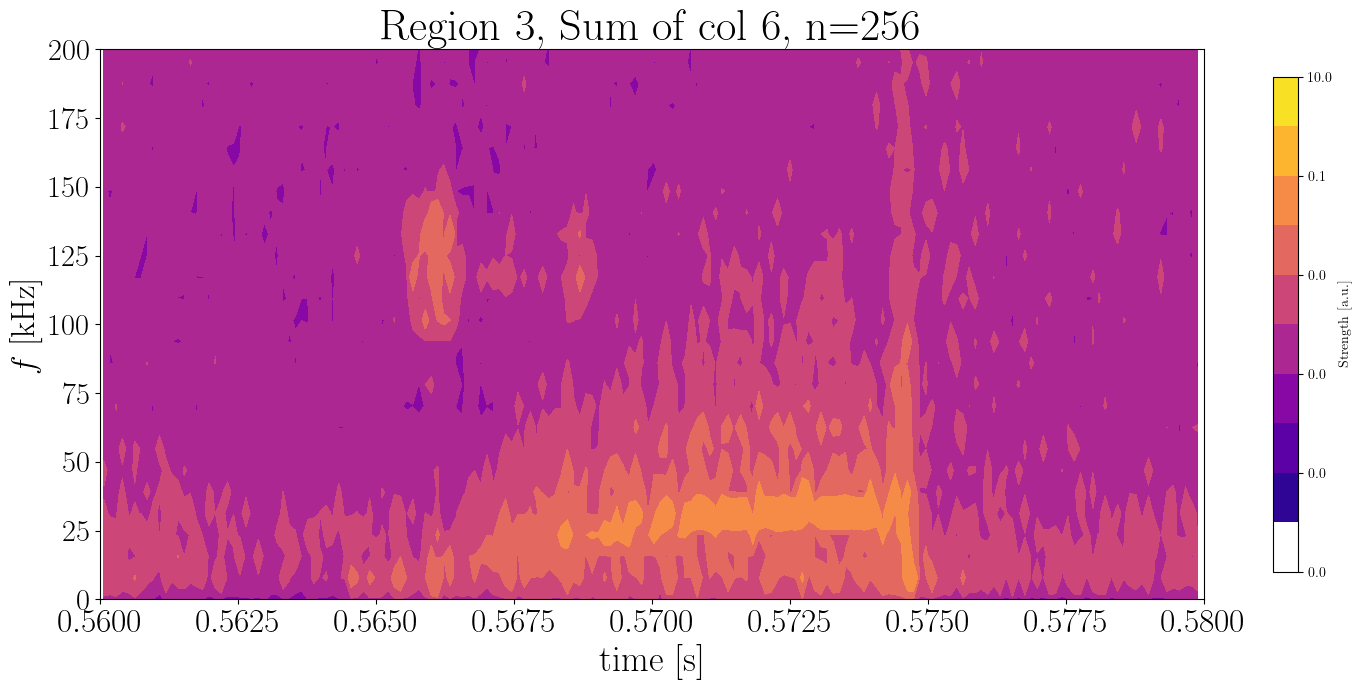

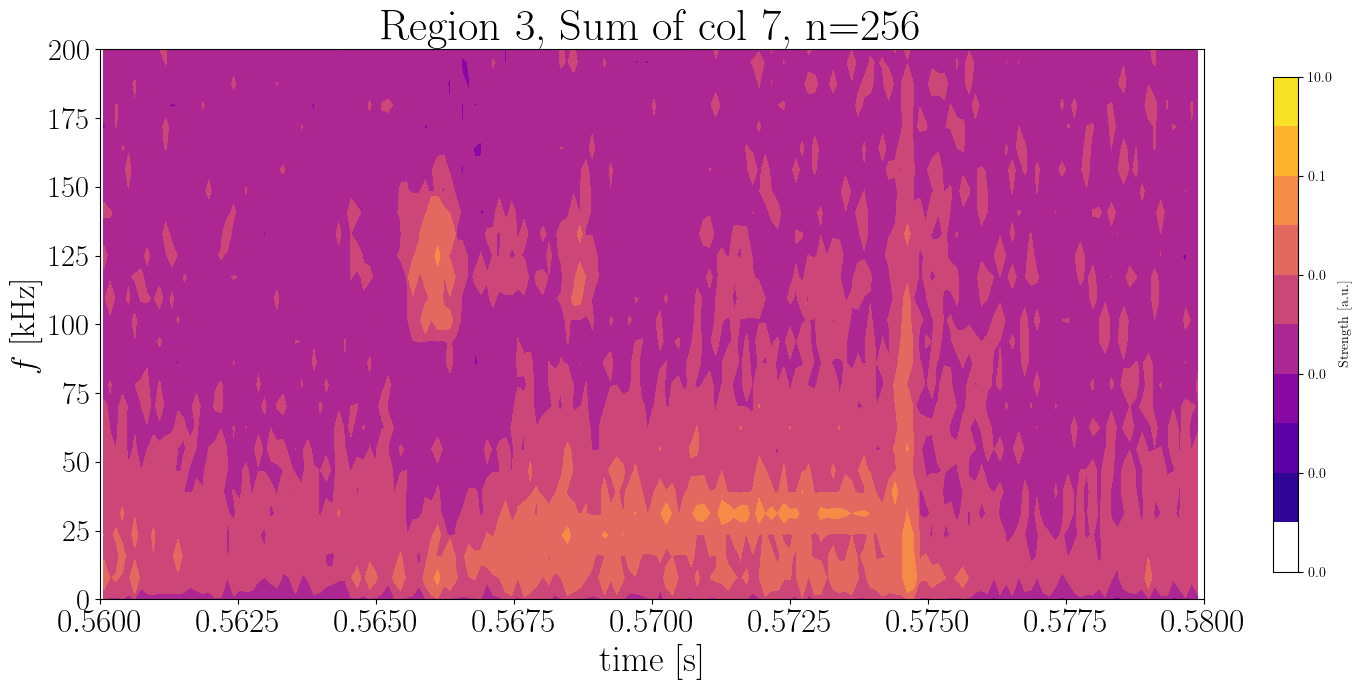

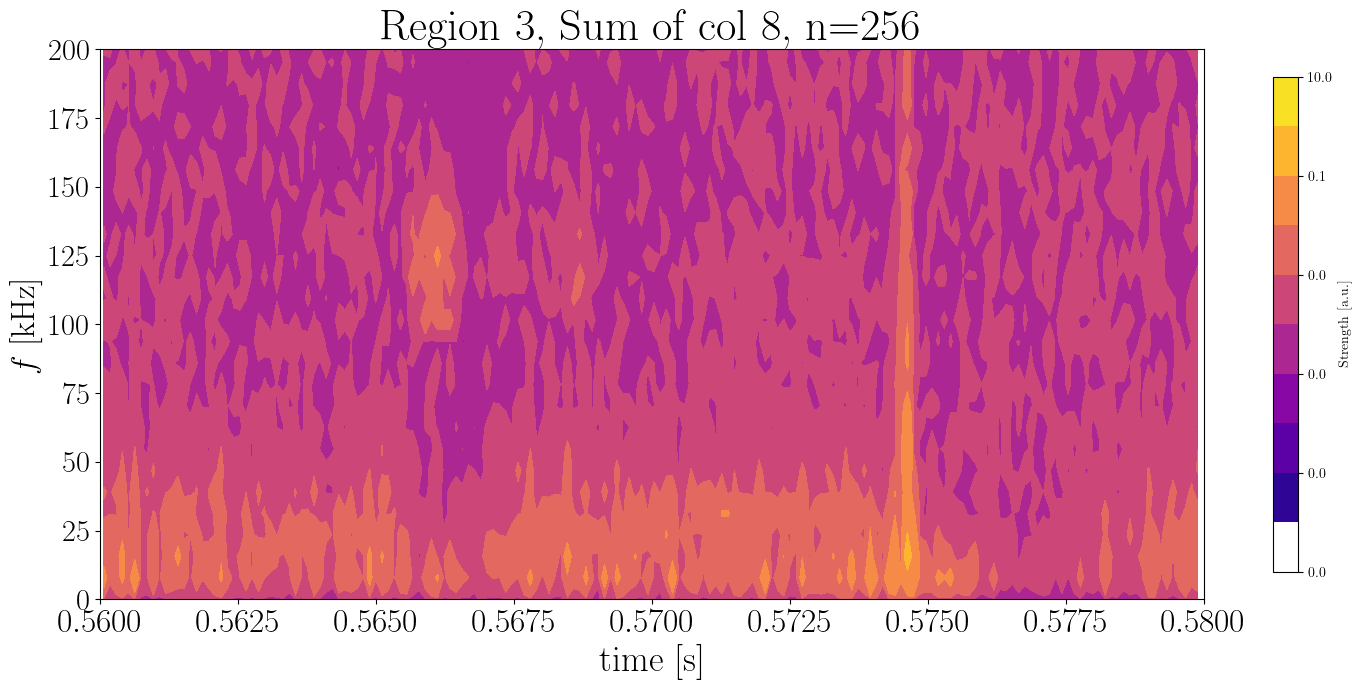

In [23]:
for col in range(8):
    sum_bes_fluct_spectrogram(bes_time, fluct_data, 2, col, [0.56,0.58], 8, plot=True, save=False)
print("")